## Spatial Indexing / Quadtree

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from algos.alg_fpd_extended import FpdExtended
import numpy as np
from bitarray import bitarray, util
import tqdm
import struct
from shapely.geometry import shape
from collections import defaultdict
import math
import random
from algos.fpd_extended_lib.compress import *

In [2]:
fpd = FpdExtended()

import bench_utils
df, unary_idxs = bench_utils.read_dataset("data/world.json")

unary_idxs = list(set(unary_idxs))
#unary_idxs = [2954, 2871, 330]
bins = []
# Compress files
for idx in tqdm.tqdm(unary_idxs): # List of single idxs
    bins.append(fpd.compress(shape(df.iloc[idx]))[1])

100%|██████████| 4446/4446 [00:17<00:00, 261.40it/s]


In [6]:
def is_bbox_contained(containee_bbox, container_bbox):
    x_l_o, y_b_o, x_r_o, y_t_o = container_bbox  # Left, bottom, right, top
    x_l_i, y_b_i, x_r_i, y_t_i = containee_bbox
    return True if x_l_o <= x_l_i and y_b_o <= y_b_i and x_r_o >= x_r_i and y_t_o >= y_t_i else False

Active tiles: 132 Number of chunks: 23
Active tiles: 333 Number of chunks: 69
Active tiles: 65 Number of chunks: 10
Active tiles: 194 Number of chunks: 35
Active tiles: 80 Number of chunks: 16
Active tiles: 110 Number of chunks: 26
Active tiles: 202 Number of chunks: 43
Active tiles: 194 Number of chunks: 36
Active tiles: 52 Number of chunks: 15
Active tiles: 272 Number of chunks: 57


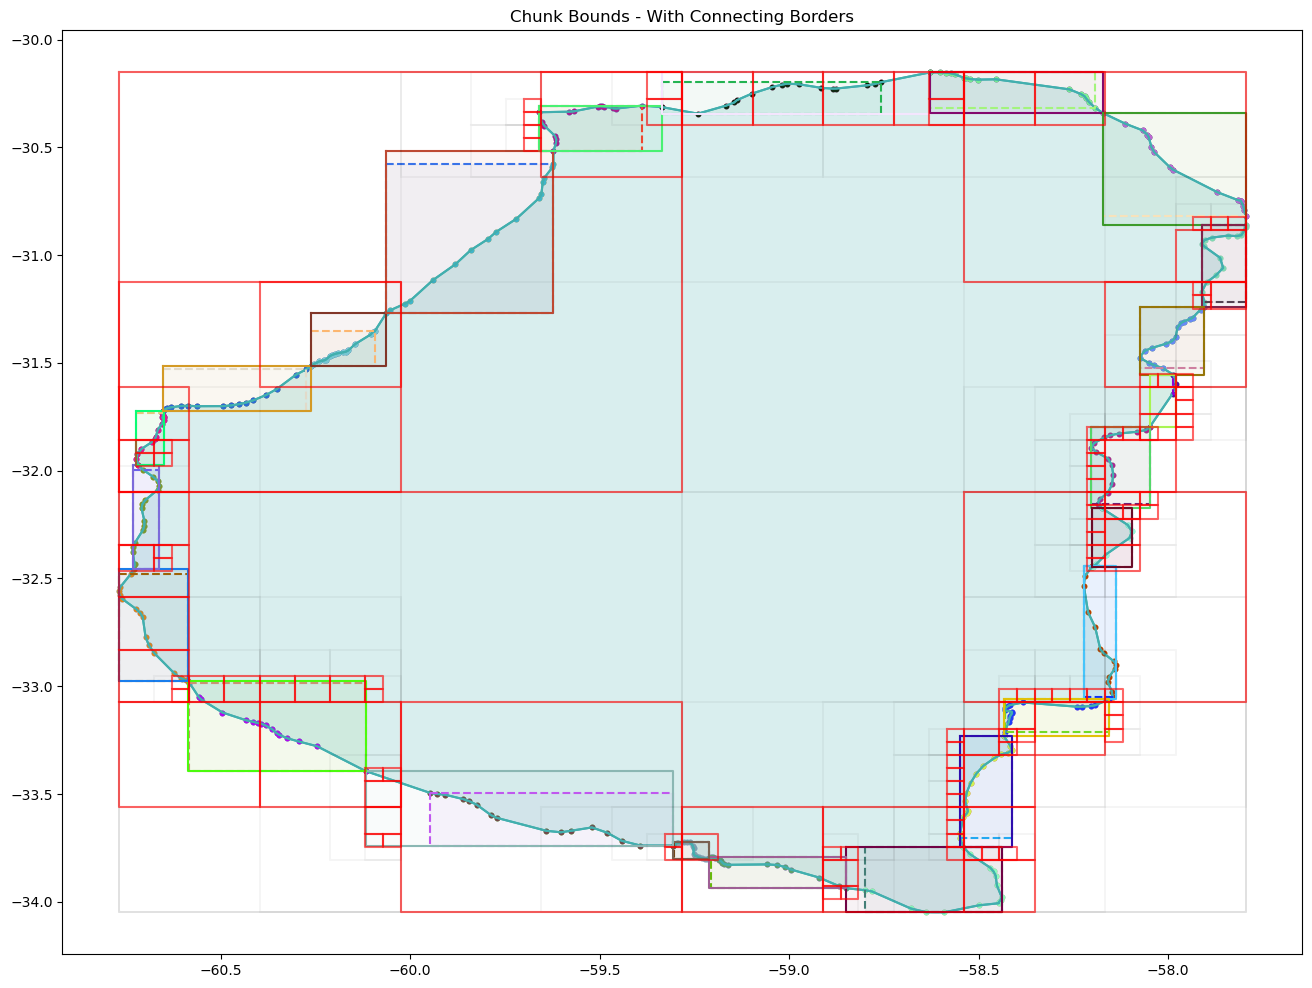

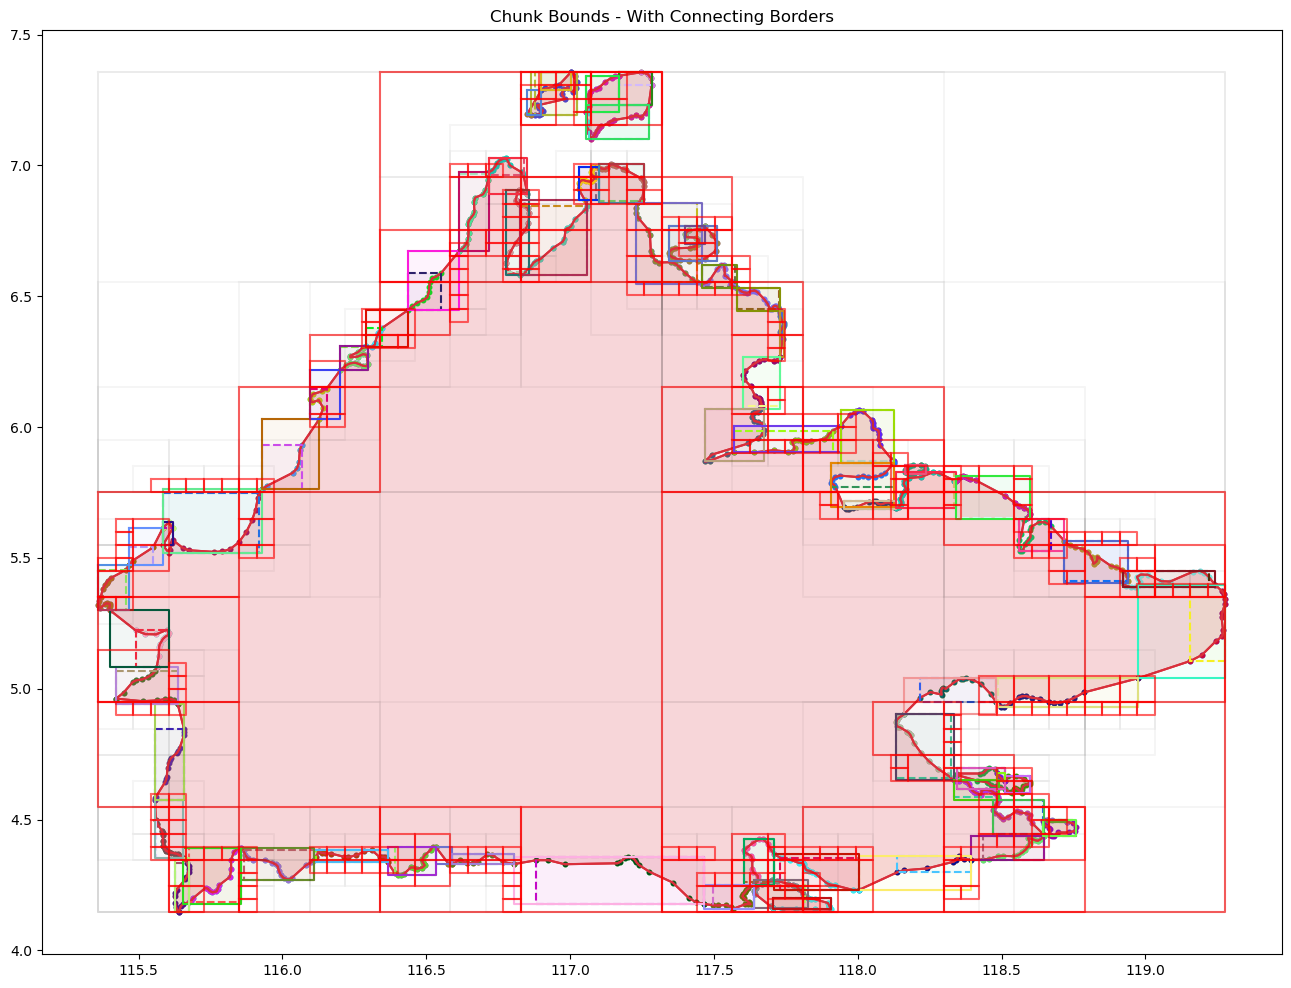

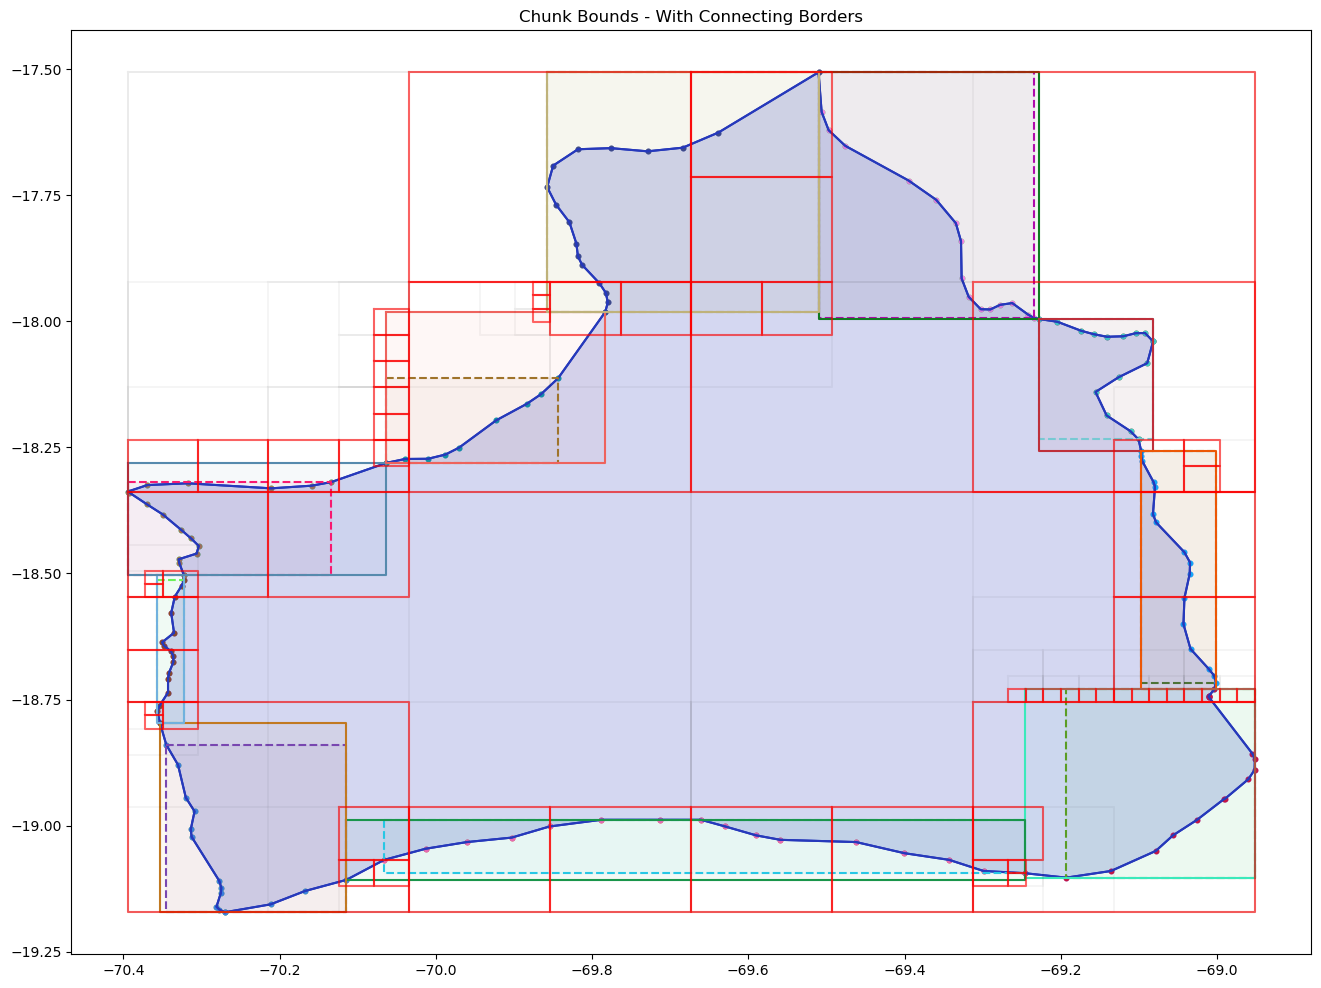

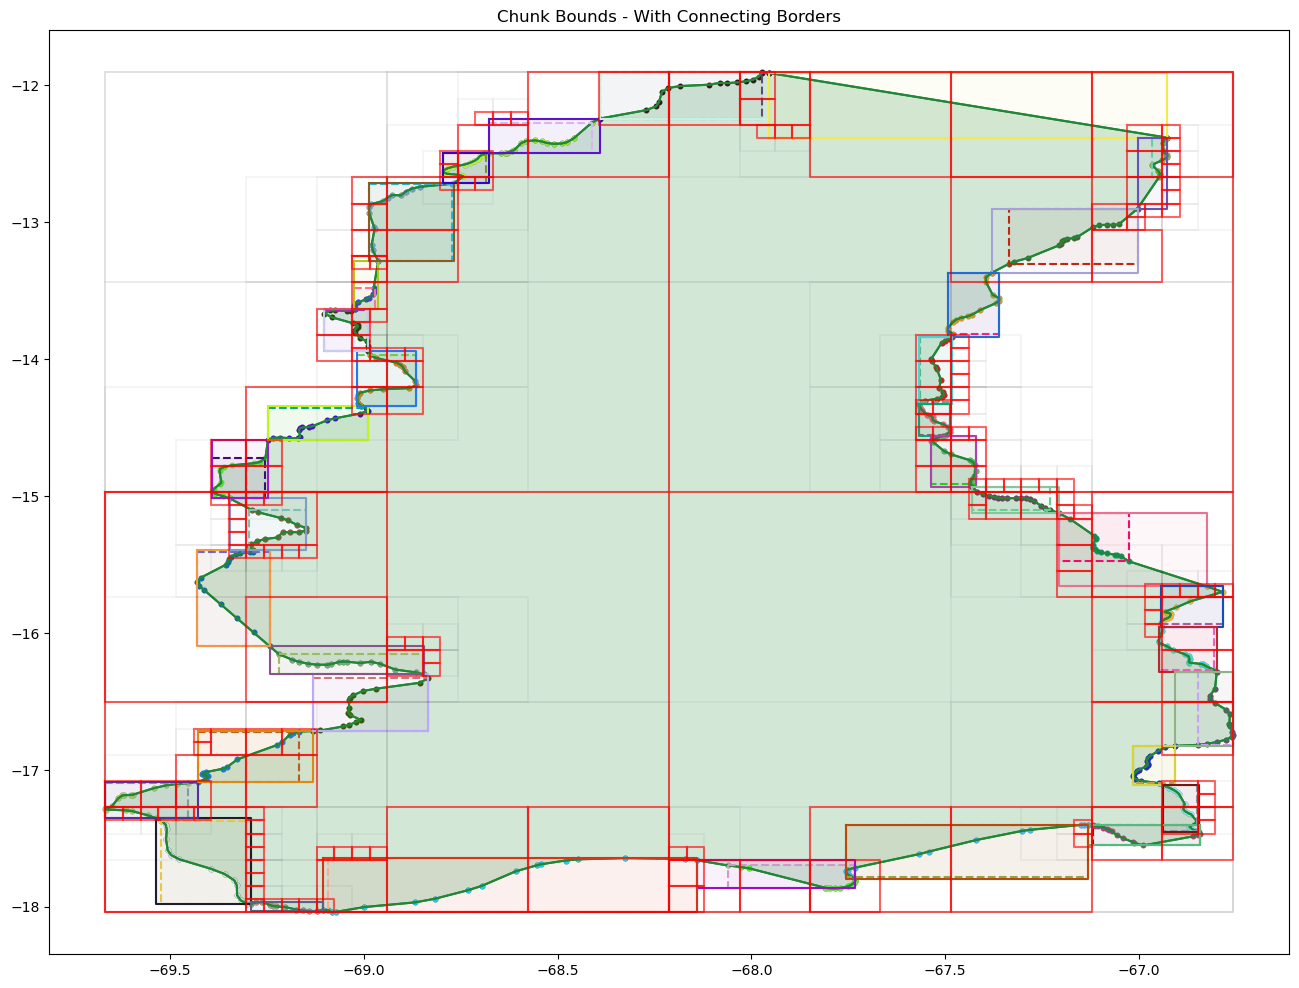

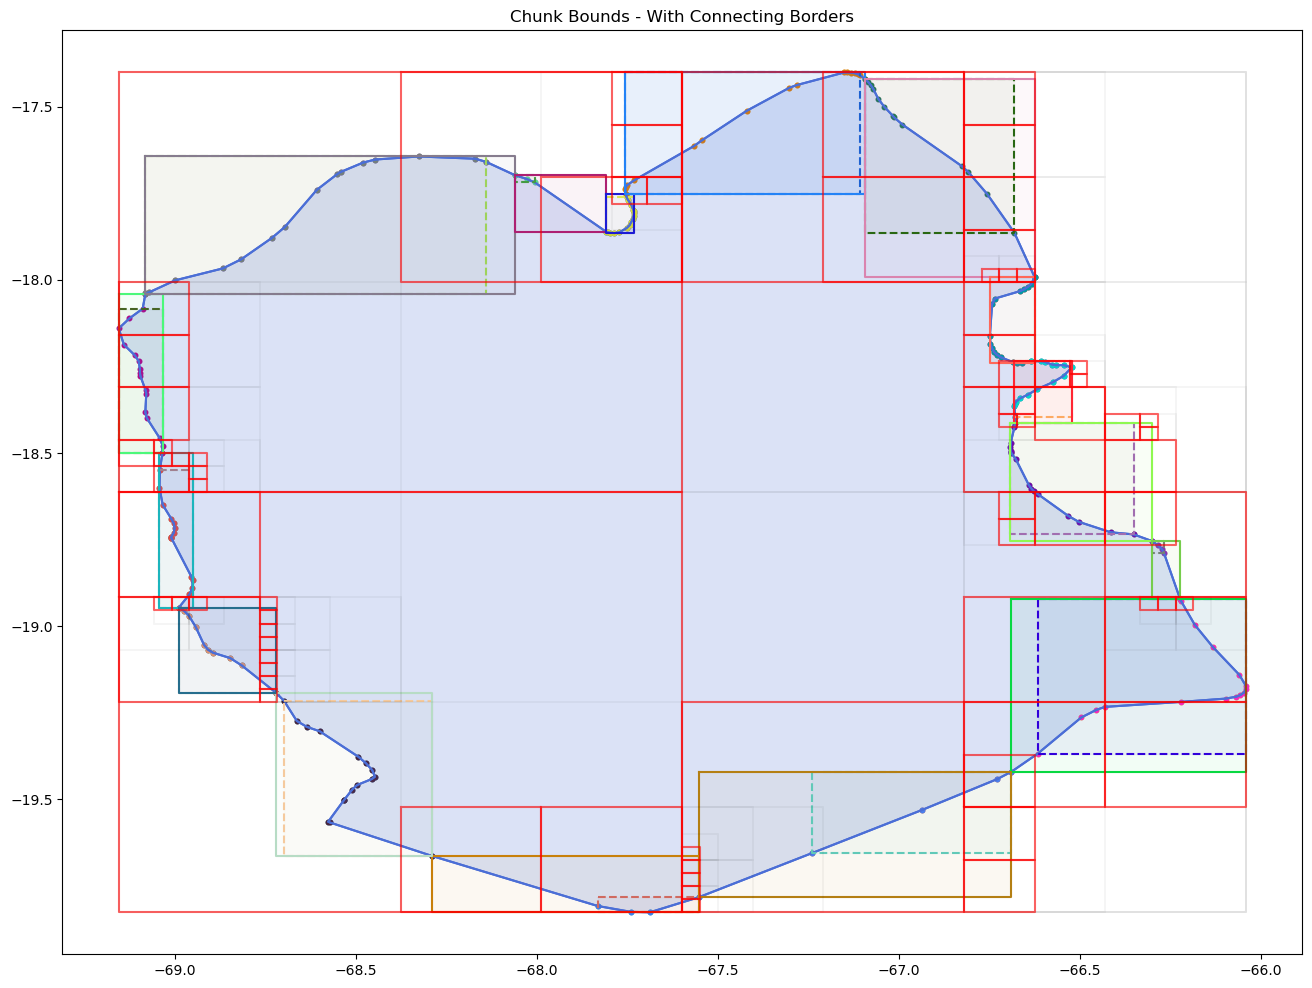

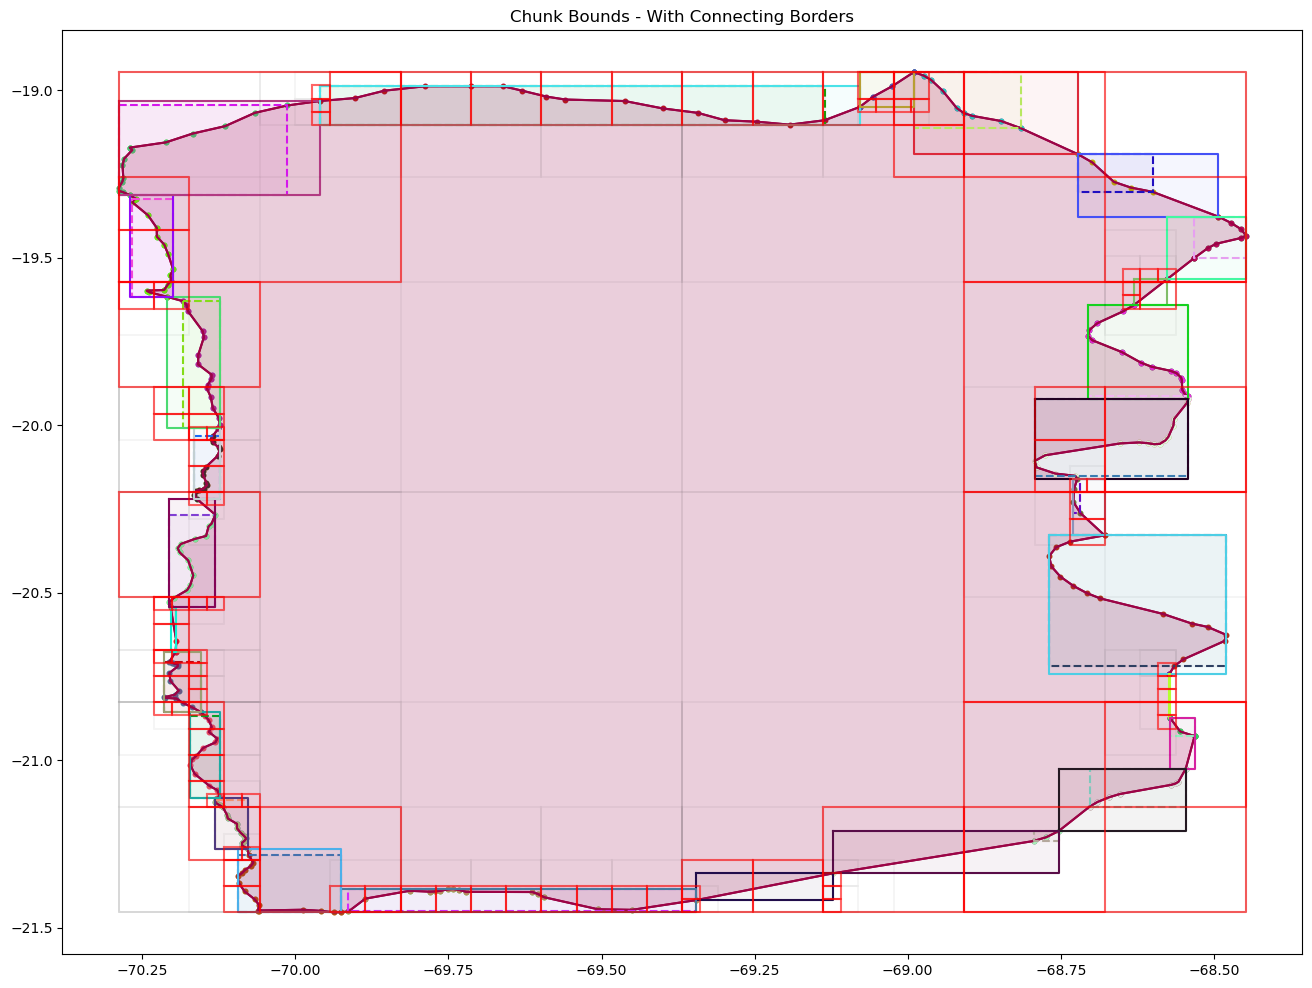

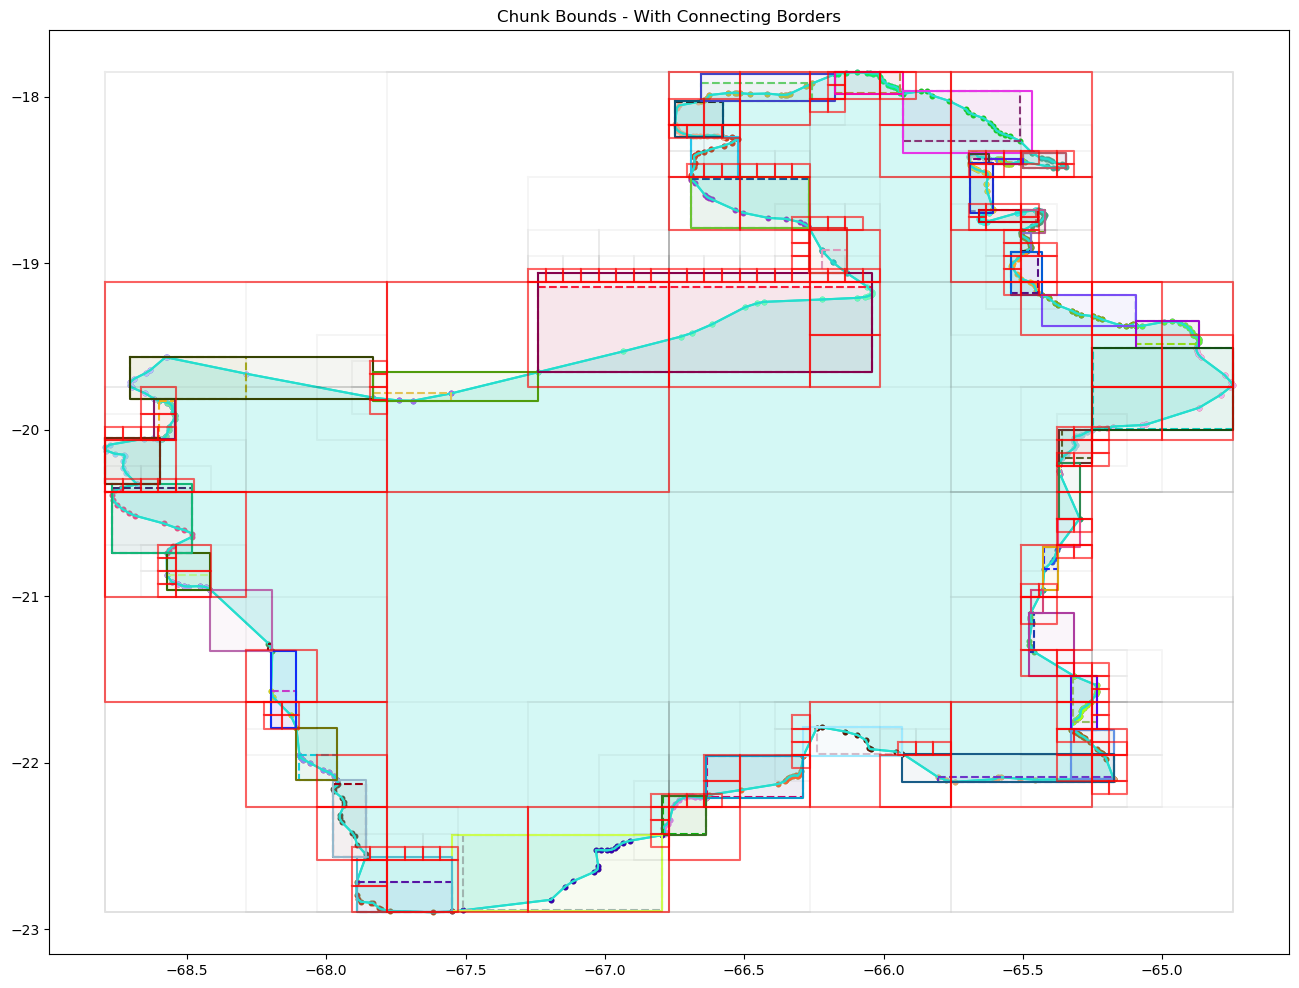

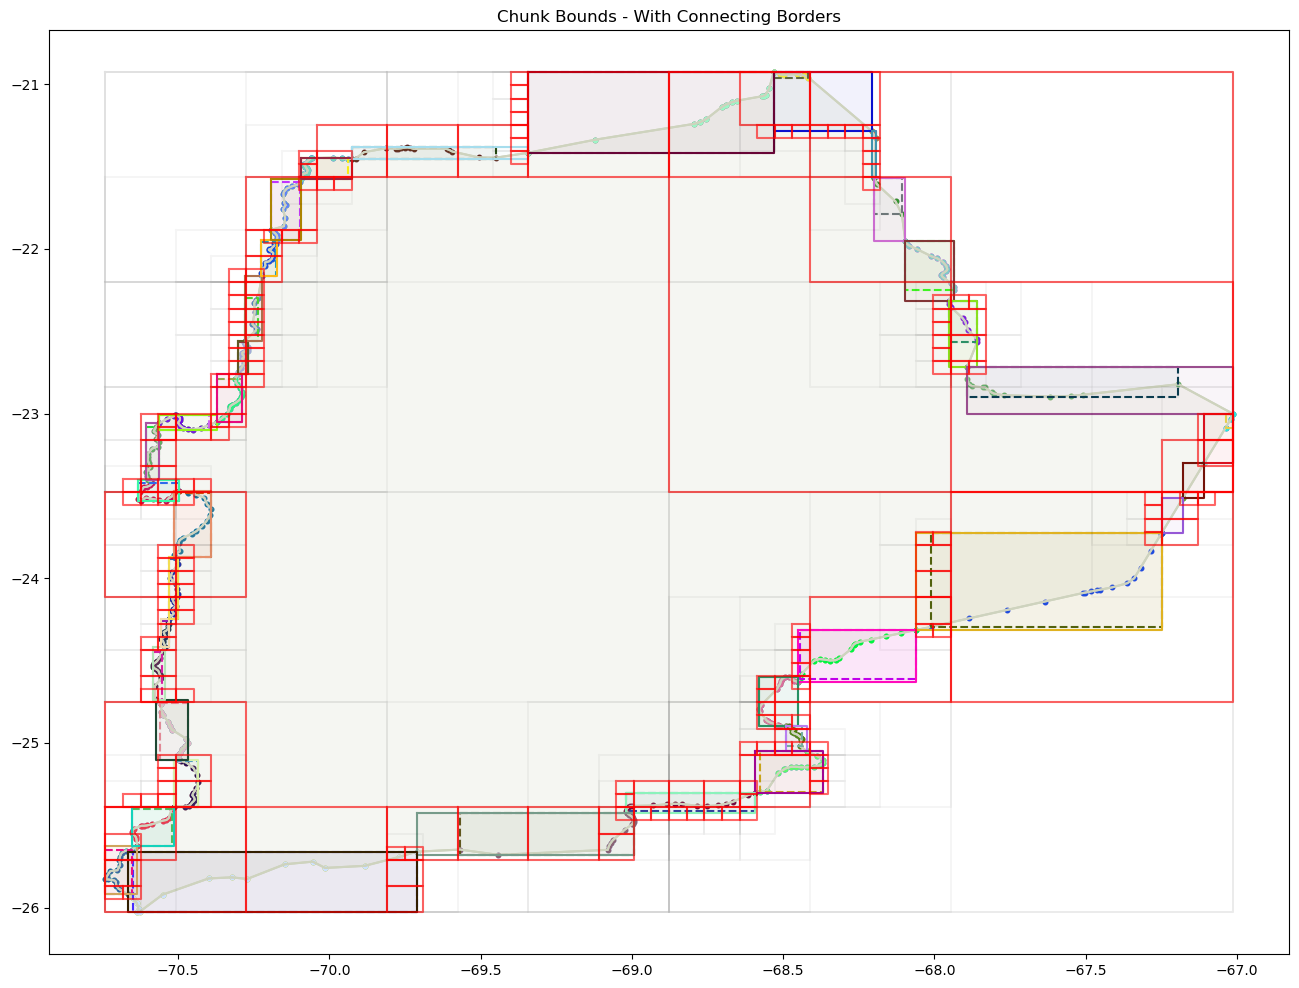

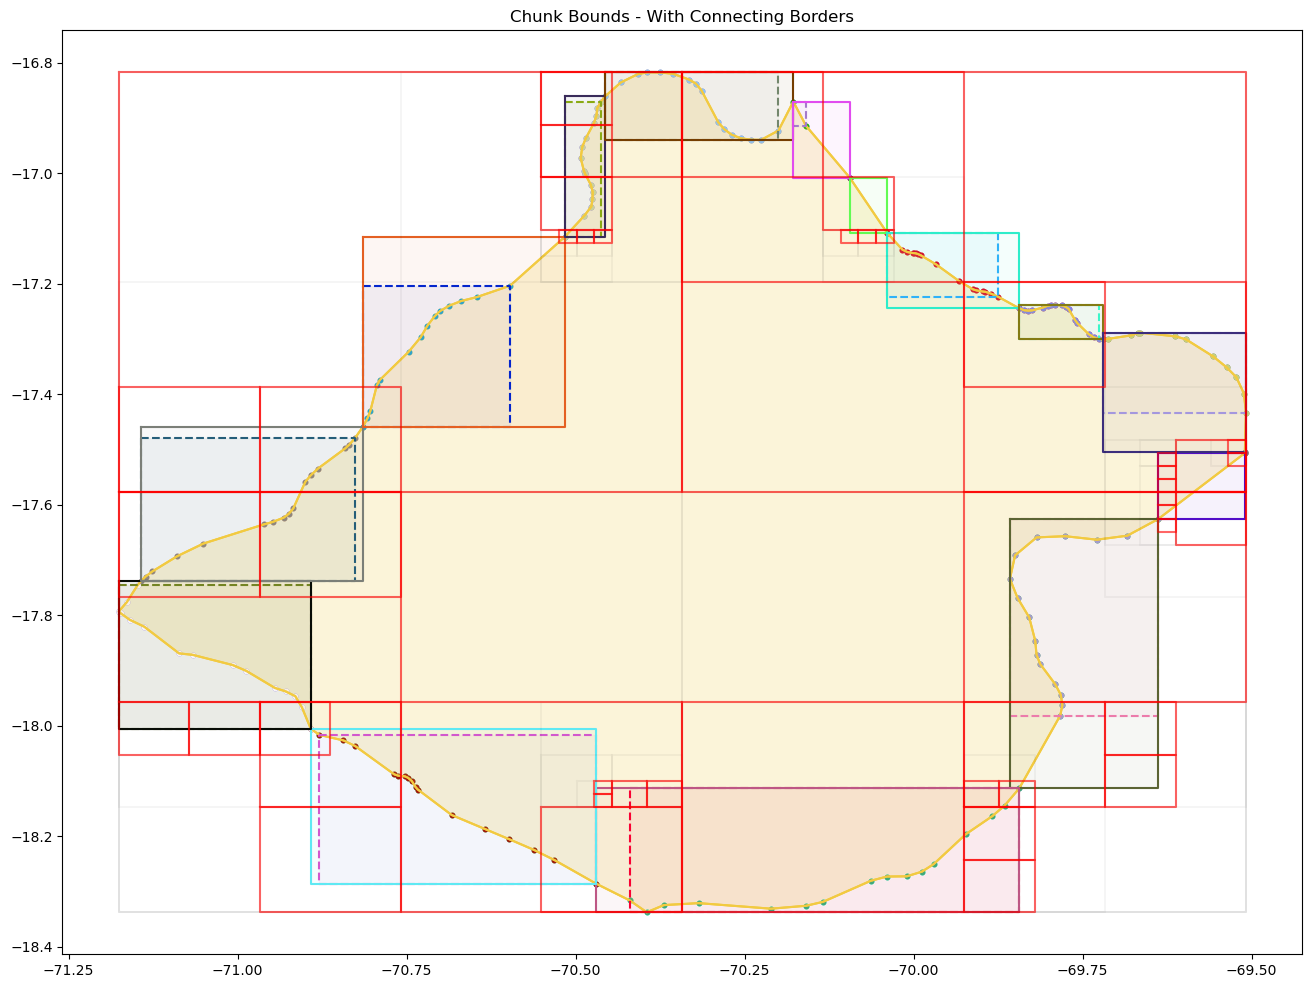

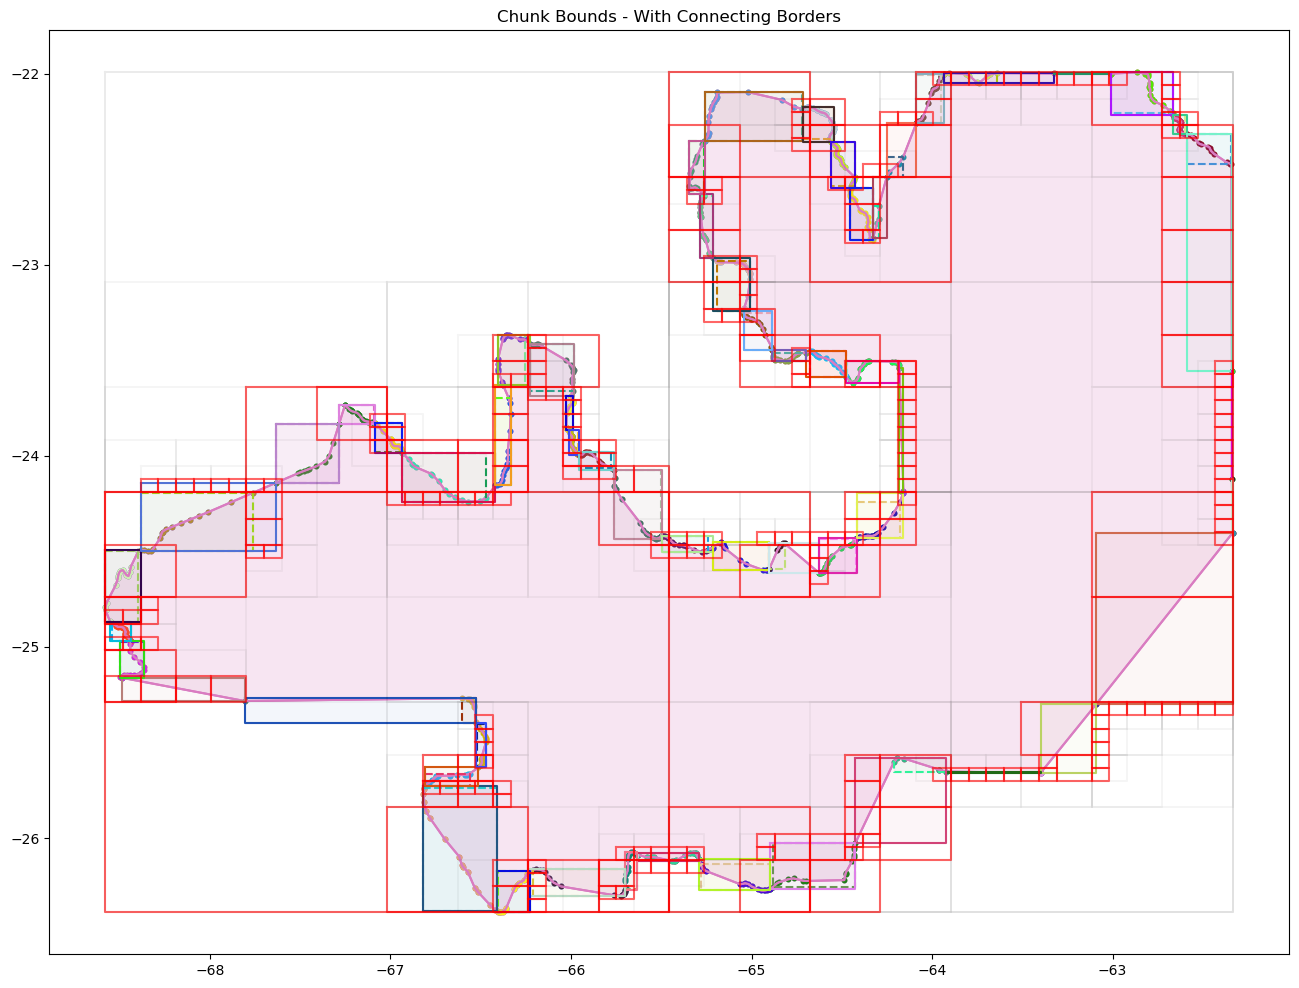

In [21]:
if True:
    from intersection.plotting import *
    from intersection.chunk_bbox_intersection import is_bbox_intersecting

    PRINT = False
    cur_active_tiles = 0
    def add_active_tile(bounds, chk_idxs):
        global cur_active_tiles
        cur_active_tiles += 1
        plot_bounds(bounds, color='red', solid=True, zorder=30, alpha=0.6)
        if PRINT:
            space = str(d)
            for _ in range(d):
                space += '    '
            print(space + str([chk_idxs]))

    MAX_DEPTH = 6
    USE_FULLY_CONTAINED_INSTEAD_OF_INTERSECTION = False

    for i in range(10):
        cur_active_tiles = 0
        idx = unary_idxs[i]
        create_canvas()
        #plot_geometry(fpd.decompress(bins[idx])[1])
        plot_chunks_bounds(bins[idx], include_next_chunk_start=False, avoid_create_frame=True, avoid_show=True, solid=False)
        plot_chunks_bounds(bins[idx], include_next_chunk_start=True, avoid_create_frame=True, avoid_show=True)
        chunks = [bbox for bbox in fpd.get_chunk_bounds(bins[idx])]
        bbox = fpd.bounding_box(bins[idx])[1]

        unprocessed = deque()
        unprocessed.append((bbox, set(range(0, len(chunks))), 0))

        while len(unprocessed) > 0:
            bounds, chk_idxs, d = unprocessed.pop()
            if not USE_FULLY_CONTAINED_INSTEAD_OF_INTERSECTION and d >= MAX_DEPTH:
                add_active_tile(bounds, chk_idxs)
                continue
            x_l, y_b, x_r, y_t = bounds
            plot_bounds(bounds, color='black', solid=True, alpha=0.04)
            
            x_mid = (x_l + x_r) / 2
            y_mid = (y_b + y_t) / 2

            top_left_bbox = (x_l, y_mid, x_mid, y_t)
            top_right_bbox = (x_mid, y_mid, x_r, y_t)
            bottom_left_bbox = (x_l, y_b, x_mid, y_mid)
            bottom_right_bbox = (x_mid, y_b, x_r, y_mid)

            d += 1

            if USE_FULLY_CONTAINED_INSTEAD_OF_INTERSECTION:
                # Fully contained
                for child_bbox in [top_left_bbox, top_right_bbox, bottom_left_bbox, bottom_right_bbox]:
                    child_chk_idxs = set(filter(lambda chk_idx: is_bbox_contained(chunks[chk_idx], child_bbox), chk_idxs))
                    chk_idxs.difference_update(child_chk_idxs)
                    #chunks child_chunks
                    if len(child_chk_idxs) > 0:
                        unprocessed.append((child_bbox, child_chk_idxs, d))

            else:
                # Intersection (more tiles)
                child_chk_idxs = [{}, {}, {}, {}]
                chks_in_all_children = chk_idxs.copy()
                for i, child_bbox in enumerate([top_left_bbox, top_right_bbox, bottom_left_bbox, bottom_right_bbox]):
                    child_chk_idxs[i] = set(filter(lambda chk_idx: is_bbox_intersecting(chunks[chk_idx], child_bbox), chk_idxs))
                    chks_in_all_children.intersection_update(child_chk_idxs[i])
                
                for i, child_bbox in enumerate([top_left_bbox, top_right_bbox, bottom_left_bbox, bottom_right_bbox]):
                    ## Comment out below for cool effect
                    child_chk_idxs[i].difference_update(chks_in_all_children)
                    if len(child_chk_idxs[i]) > 0:
                        unprocessed.append((child_bbox, child_chk_idxs[i], d))
            
                chk_idxs = chks_in_all_children
                
            if len(chk_idxs) > 0:
                add_active_tile(bounds, chk_idxs)
        if PRINT:
            print('\n')
        print("Active tiles:", cur_active_tiles, "Number of chunks:", len(chunks))